# Imports

In [1]:
import os
import tarfile
import jdc      #for class handling in jupyter
import numpy as np

# Part1

In [2]:
#!wget -N http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz

In [3]:
def read_tar():
    # open file 
    review_file = tarfile.open('review_polarity.tar.gz') 
  
    # extracting file 
    review_file.extractall('.') 
  
    review_file.close() 

In [4]:
"""_summary_
grab data from directory paths and lists
"""
def get_data(dir_list, dir_path, review_polarity):
  words = set()
  reviews = []
  sentiment = []
  
  for file_name in dir_list:
      if isinstance(file_name, str):
          f = open(os.path.join(dir_path, file_name),'r')
          review = f.read()
          reviews.append(review)
          words = words|set(review.split()) 
          sentiment.append(review_polarity)
          f.close()
  return np.array(reviews), np.array(sentiment), words

In [5]:
index_dict = {} #dictionary of words:index in bag of words vector
#read_tar()
neg_path = 'txt_sentoken/neg'
pos_path = 'txt_sentoken/pos'
neg_files = os.listdir(neg_path)
pos_files = os.listdir(pos_path)

neg_rev, neg_sent, neg_words = get_data(neg_files, neg_path, -1)
pos_rev, pos_sent, pos_words = get_data(pos_files, pos_path, 1)
#form word bag, X_raw, and prediction sets
words = neg_words|pos_words
X_raw = np.concatenate((neg_rev,pos_rev),axis=0)
y_raw = np.concatenate((neg_sent,pos_sent),axis=0)
sorted_words = sorted(words)

In [6]:
#shuffles both predictions and raw data with same permutation.
def shuffle(data, labels):
    p = np.random.permutation(len(data))
    return data[p], labels[p], p

In [7]:
X_shuffled, y_shuffled, p = shuffle(X_raw, y_raw)

In [8]:
print(p[:8],y_shuffled[:8], y_raw[p[:8]]) #could just be asserts i guess
print(X_shuffled[:8] == X_raw[p[:8]])

[ 278  173  328  463 1541  401  113 1813] [-1 -1 -1 -1  1 -1 -1  1] [-1 -1 -1 -1  1 -1 -1  1]
[ True  True  True  True  True  True  True  True]


In [9]:
print(X_shuffled[0][:10])

keep cool 


In [10]:
X_shuffled.shape

(2000,)

dimensions look good! now to move onto implementing BOW

# Part2


In [11]:
"""_summary_
transform x into a sparse BoW array. implementation part 2
"""
class Vectorizer:
  def __init__(self, sorted_vocab, tokenizer = 'none'):
    self.tokenizer = tokenizer
    self.index_dict = dict()
    for i, word in enumerate(sorted_vocab):
      self.index_dict[word] = i
  
  def transform(self, data):
    sparse_data = []
    for review in data:
      review_list = review.split()              #replace with tokenizer if needed
      sparse_review = np.zeros(len(self.index_dict))
      for word in review_list:
          sparse_review[self.index_dict[word]] = 1
      sparse_data.append(sparse_review)
            
    assert len(data) == len(sparse_data)        #is the output array the same length as input?
    assert sum(sparse_data[0]) != 0             #do these sparse arrays contain anything?
    
    return np.array(sparse_data)

In [12]:
victor = Vectorizer(sorted_words)

In [13]:
index_dict = dict()
for i, word in enumerate(sorted_words):
  index_dict[word] = i

for word in ['dolphin', 'the', 'coffee']:
  if word in sorted_words:
    print("'%s' is represented as feature dimension %i" %(word, index_dict[word]))
  else:
    print("'%s' is not in the vocabulary" % word)

'dolphin' is represented as feature dimension 13868
'the' is represented as feature dimension 45372
'coffee' is represented as feature dimension 9677


In [14]:
X_BOW = victor.transform(X_shuffled)            #output should be bag of words rep of sentence

In [15]:
X_BOW[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
X_BOW.shape

(2000, 50920)

# Part3
**Implementation task:** You should implement your versions of the following parts (you can also find this in the slides):

In [59]:
class model:
  def __init__(self, eta0 = 0.001, loss = 'hinge', alpha = .0001, learning_rate = "constant", penalty = 'L2', random_state = 'none',
               tol = 5, early_stop = False):
    
    self.loss = loss  #hinge loss default probably won't try others
    self.loss_history = []
    self.lr, self.eta0 = eta0, eta0  #starting learning rate
    self.alpha = alpha #regularization dampener
    self.learning_rate = learning_rate  #constant learning rate or schedule?
    self.penalty = penalty #penalty for hinge loss probably won't play with this
    self.tol = tol  
    self.n_max_iterations = 400
    self.early_stop = early_stop
    
  def fit(self, X, y):
    """Does the training. X is a matrix with one data point per row, while y is flat."""
    self.weights = np.random.normal(loc=0,scale=.5,size=X.shape[1])
    
    self.weight_history = [self.weights.copy()]
    self.loss_history = [self.score(X,y)]
    iter_wo_improve = 0
    
    for i in range(self.n_max_iterations):
      self._fit(X,y)
      if len(self.loss_history)>1 and self.loss_history[-2]-.001 < self.loss_history[-1]:
        iter_wo_improve += 1  #using best instead of last entry meant i had to have insanely high tolerances and rollback if the loss jumped in the beginning, so we aren't doing that.
      else:
        iter_wo_improve = 0
      if iter_wo_improve >= self.tol: #stop criterion
        if self.early_stop == False:
          break
        else:
          self.weights = self.weight_history[-iter_wo_improve] # early stop & rollback. useful if we have val set, maybe nothing I need here.
          return self.weight_history[-iter_wo_improve], self.loss_history[-iter_wo_improve] , i
      
    return self.weight_history[-1], self.loss_history[-1] , i 
      
  """gradient descent
  calculate vector of greatest slope and mod weights."""
  def _fit(self, X, y):
    sign_term = np.sign(np.maximum(0,1-y*X.dot(self.weights)))[:,np.newaxis]
    grad_per_review = -y[:,np.newaxis]*X*sign_term
    grad_sum = np.sum(grad_per_review,axis=0)   #sum across reviews for aggregate weight gradients

    gradient = self.alpha*self.weights + grad_sum
    
    self.weights -= self.lr*gradient
    
    self.loss_history.append(self.score(X,y))
    self.weight_history.append(self.weights.copy())
    
  """hyperplane"""
  def predict(self, X):
    return np.sign(X.dot(self.weights))
  
  """hinge loss. output loss vector for... weights or reviews?"""
  def score(self, X, y):
    norm_term = self.alpha/2*np.linalg.norm(self.weights)**2
    sum_term = np.sum(np.maximum(0,1-y*X.dot(self.weights))) #sum across reviews
    return norm_term + sum_term
  

In [60]:
reguliser_dampening = 0.001   # lambda
learning_rate = 0.001         # gamma
X_BOW_intc = np.concatenate((np.ones_like(y_shuffled)[:,np.newaxis],X_BOW),axis=1) #intercept array

# Create the untrained classifier
classy = model(loss='hinge', penalty='l2',
                      alpha=reguliser_dampening,
                      learning_rate='constant', eta0=learning_rate)

# Train the classifier
best_weight, best_loss, iter = classy.fit(X_BOW_intc, y_shuffled)

# Get the parameter vector
omega = best_weight

In [61]:
training_accuracy = np.sum(classy.predict(X_BOW_intc)==y_shuffled)/len(y_shuffled)
training_accuracy

0.888

In [62]:
iter

70

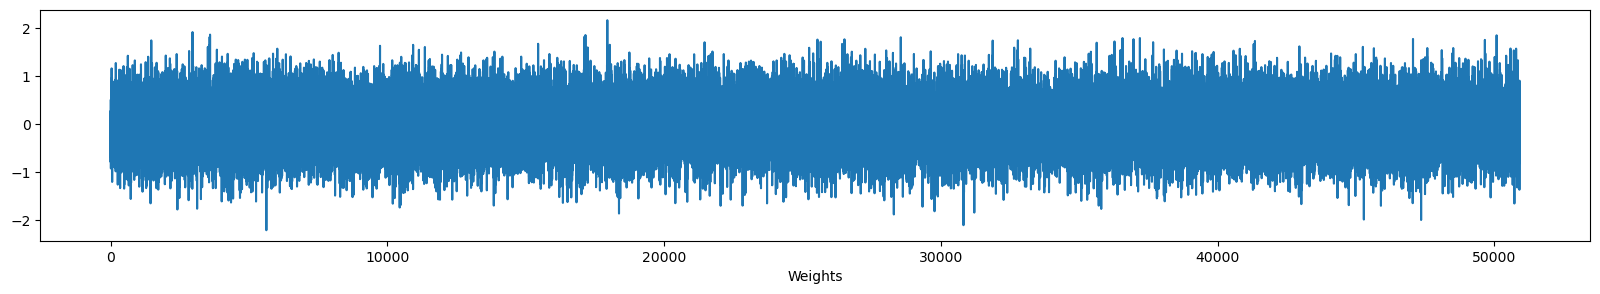

In [63]:
import matplotlib.pyplot as plt
 
plt.figure(figsize=(20, 3))
plt.plot(np.random.normal(loc=0,scale=.5,size=X_BOW.shape[1]))
plt.xlabel("Value")
plt.xlabel("Weights")
plt.show()

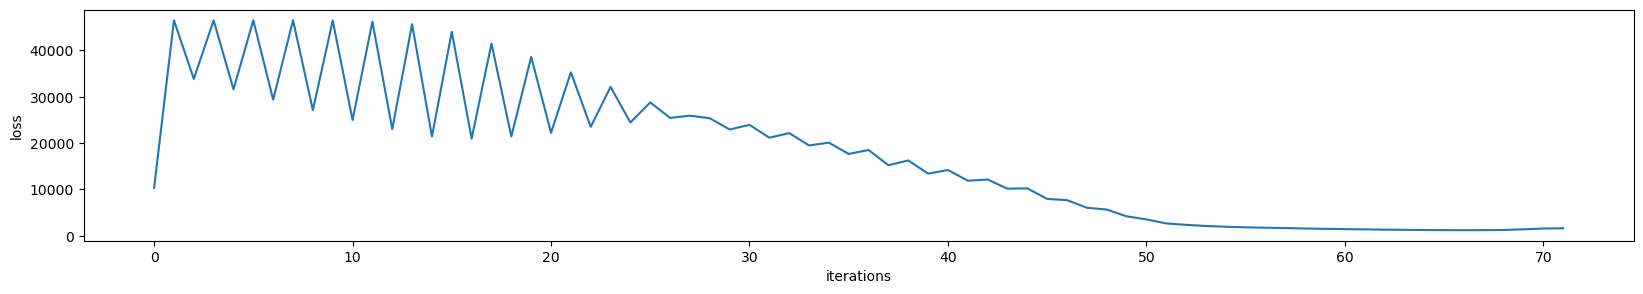

In [64]:
plt.figure(figsize=(20, 3))
plt.plot(classy.loss_history)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.show()

In [65]:
assert (len(omega)-1) == len(sorted_words)

# Sort by absolute value
idx = np.argsort(np.abs(omega[1:]))

print("                Word   Weight  Occurences")
for i in idx[-20:]:   # Pick those with highest 'voting' values
  print("%20s   %.3f\t%i " % (sorted_words[i], omega[i+1], np.sum([sorted_words[i] in d for d in X_raw])))

                Word   Weight  Occurences
            terrific   2.140	104 
                view   2.158	842 
              begins   2.174	321 
              moving   2.273	174 
                also   2.289	1071 
              stupid   -2.344	227 
             nothing   -2.344	594 
           perfectly   2.352	146 
                very   2.489	1552 
        surprisingly   2.500	185 
       unfortunately   -2.523	329 
           different   2.601	370 
              boring   -2.630	229 
              script   -2.707	632 
                 job   2.752	480 
             perfect   2.760	403 
            supposed   -2.767	321 
                plot   -2.826	1002 
               worst   -3.513	238 
                 bad   -4.510	825 


cool beans

# Part4
**Implementation task:** Implement code for printing a sorted table of your sampled hyperparameters. Note, you do not have to reimplement the grid search.

In [68]:
#split training and test data 80:20. they're already shuffled so just slice em.
proportion = .8
split_point = int(len(X_BOW_intc)*proportion)

X_train = X_BOW_intc[:split_point]
X_test = X_BOW_intc[split_point:]

y_train = y_shuffled[:split_point]
y_test = y_shuffled[split_point:]

In [70]:
#Hyperparameter search
parameter_distribution = {'learning_rate': np.exp(np.linspace(np.log(0.0001), np.log(3), 10)),
                          'reguliser_dampening': np.exp(np.linspace(np.log(0.0001), np.log(3), 10))}
best_model = None

print("Learning rate:\tReg.dampening:\tTraining set accuracy:")

for lr in parameter_distribution['learning_rate']:
    for reg in parameter_distribution['reguliser_dampening']:
        classy = model(loss='hinge', penalty='l2',
                      alpha=reg,
                      learning_rate='constant', eta0=lr)
        
        weight, loss, iter = classy.fit(X_train,y_train)
        training_accuracy = np.sum(classy.predict(X_train)==y_train)/len(y_train)

        if best_model is None or best_model[1] < training_accuracy:
            best_model = ((lr,reg), training_accuracy, weight, classy.weight_history[iter-5])
        print("%.5f\t\t%.5f\t\t%.1f%%" % (lr, reg, 100*training_accuracy))

best_lr = best_model[0][0]
best_reg = best_model[0][1]
print("Best parameters: %.5f, %.5f" % (best_lr, best_reg))

Learning rate:	Reg.dampening:	Training set accuracy:
0.00010		0.00010		92.8%
0.00010		0.00031		93.9%
0.00010		0.00099		94.7%
0.00010		0.00311		94.2%
0.00010		0.00977		94.1%
0.00010		0.03071		94.9%
0.00010		0.09655		95.8%
0.00010		0.30353		95.6%
0.00010		0.95425		94.2%
0.00010		3.00000		95.6%
0.00031		0.00010		55.3%
0.00031		0.00031		74.3%
0.00031		0.00099		58.2%
0.00031		0.00311		90.8%
0.00031		0.00977		79.2%
0.00031		0.03071		55.4%
0.00031		0.09655		57.3%
0.00031		0.30353		89.3%
0.00031		0.95425		76.4%
0.00031		3.00000		86.1%
0.00099		0.00010		88.6%
0.00099		0.00031		100.0%
0.00099		0.00099		76.3%
0.00099		0.00311		100.0%
0.00099		0.00977		88.4%
0.00099		0.03071		100.0%
0.00099		0.09655		89.4%
0.00099		0.30353		100.0%
0.00099		0.95425		89.6%
0.00099		3.00000		75.4%
0.00311		0.00010		100.0%
0.00311		0.00031		100.0%
0.00311		0.00099		100.0%
0.00311		0.00311		100.0%
0.00311		0.00977		100.0%
0.00311		0.03071		100.0%
0.00311		0.09655		100.0%
0.00311		0.30353		100.0%
0.00311		0.95425		92.7%

# Final evaluation

In [79]:
# Set up the classifier
classiest = classy  #yes I know this isn't a copy
classiest.weights = best_model[2]
# Run prediction on the test set
test_accuracy = np.sum(classiest.predict(X_test)==y_test)/len(y_test)

#reset weights to earliest point when performance was best
classiest.weights = best_model[3]
test_accuracy_early = np.sum(classiest.predict(X_test)==y_test)/len(y_test)

print("Low param test set accuracy %.1f%%" % (100*test_accuracy))
print("Early Stop test set accuracy %.1f%%" % (100*test_accuracy_early))


Low param test set accuracy 83.0%
Early Stop test set accuracy 82.0%


In [82]:
#since I forgot to provide a way to save the other weights i wanted to test, we'll just retrain
#3.00000	0.00031 stable high learning rate, alpha
more_classiest = model(loss='hinge', penalty='l2',
                      alpha=0.00031,
                      learning_rate='constant', eta0=3)

# Train on all the non-test data
more_classiest.fit(X_train, y_train)

# Run prediction on the test set
test_accuracy = np.sum(more_classiest.predict(X_test)==y_test)/len(y_test)

#reset weights to earliest point when performance was best
classiest.weights = best_model[3]
test_accuracy_early = np.sum(classiest.predict(X_test)==y_test)/len(y_test)

print("High param test set accuracy %.1f%%" % (100*test_accuracy))
print("Early Stop test set accuracy %.1f%%" % (100*test_accuracy_early))

High param test set accuracy 85.2%
Early Stop test set accuracy 82.0%
